In [142]:
import numpy as np
import torch

import scipy.io
import mat73

import sparse

from tqdm.notebook import tqdm
from scipy.sparse.linalg import norm

import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

In [143]:
path = input('Enter reconstruction errors file path: ')
try:
    errors = scipy.io.loadmat(path)['slice_fits']
except:
    errors = mat73.loadmat(path)['slice_fits']

errors = np.array(errors)

In [144]:
dataset = pd.read_csv(input('Enter dataset path: ')).to_numpy()

data, labels = dataset[:, 0], dataset[:, 1]
data, labels = shuffle(data, labels, random_state=10)

data, labels = data[:len(errors)], labels[:len(errors)]

In [145]:
vals = {label: [value for gtruth, value in zip(labels, errors) if gtruth == label] for label in labels}

In [146]:
for label, rec_errors in vals.items():
    print(f"Key: {label}, Length of List: {len(rec_errors)}")

Key: 0, Length of List: 83
Key: 1, Length of List: 17


<Axes: ylabel='Count'>

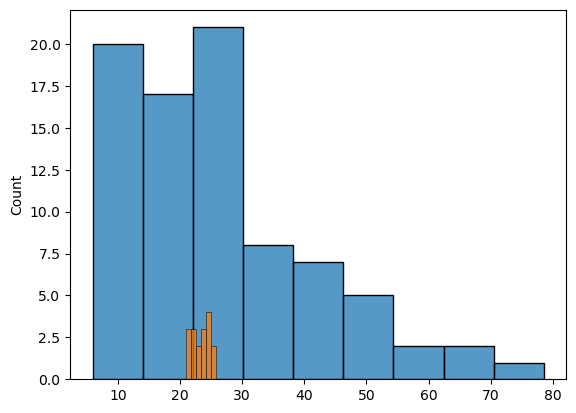

In [147]:
sns.histplot(vals[0])
sns.histplot(vals[1])

# Models

In [148]:
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.kde import KDE
from pyod.models.cblof import CBLOF
from pyod.models.gmm import GMM

from pyod.models.xgbod import XGBOD
from pyod.models.knn import KNN


from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize


In [149]:
X_train, X_test, y_train, y_test = train_test_split(np.array(errors).reshape(-1, 1), labels.astype(int), test_size=0.33, random_state=42)

In [150]:
lof = LOF()
model_name = type(lof).__name__

lof.fit(X_train, y_train)

/home/zqazi004/miniconda3/envs/anom_detect/lib/python3.8/site-packages/pyod/models/base.py:431: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2)

In [151]:
y_train_pred = lof.labels_
y_train_scores = lof.decision_scores_

y_test_pred = lof.predict(X_test) 
y_test_scores = lof.decision_function(X_test) 
y_test_proba = lof.predict_proba(X_test)

In [152]:
evaluate_print(model_name, y_test, y_test_scores)

LOF ROC:0.0388, precision @ rank n:0.0


In [153]:
print(f'{model_name} Classification Report:\n')
print(classification_report(y_test, y_test_pred))

LOF Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.00      0.00      0.00         4

    accuracy                           0.82        33
   macro avg       0.44      0.47      0.45        33
weighted avg       0.77      0.82      0.79        33



## Isolation Forest

In [154]:
ifor = IForest(behaviour='new')

model_name = type(ifor).__name__

ifor.fit(X_train, y_train)

/home/zqazi004/miniconda3/envs/anom_detect/lib/python3.8/site-packages/pyod/models/base.py:431: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [155]:
y_train_pred = ifor.labels_
y_train_scores = ifor.decision_scores_

y_test_pred = ifor.predict(X_test) 
y_test_scores = ifor.decision_function(X_test) 
y_test_proba = ifor.predict_proba(X_test)

evaluate_print(model_name, y_test, y_test_scores)

## KDE

In [ ]:
kde = KDE()

model_name = type(kde).__name__

kde.fit(X_train, y_train)

/home/zqazi004/miniconda3/envs/anom_detect/lib/python3.8/site-packages/pyod/models/base.py:431: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


KDE(algorithm='auto', bandwidth=1.0, contamination=0.1, leaf_size=30,
  metric='minkowski', metric_params=None)

In [ ]:
y_train_pred = kde.labels_
y_train_scores = kde.decision_scores_

y_test_pred = kde.predict(X_test) 
y_test_scores = kde.decision_function(X_test) 
y_test_proba = kde.predict_proba(X_test)

evaluate_print(model_name, y_test, y_test_scores)

KDE ROC:0.0517, precision @ rank n:0.0


## CBLOF

In [ ]:
clf = CBLOF()
clf.fit(X_train, y_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('CBLOF', y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print('CBLOF', y_test, y_test_scores)

/home/zqazi004/miniconda3/envs/anom_detect/lib/python3.8/site-packages/pyod/models/base.py:431: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/zqazi004/miniconda3/envs/anom_detect/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



On Training Data:
CBLOF ROC:0.463, precision @ rank n:0.0769

On Test Data:
CBLOF ROC:0.2931, precision @ rank n:0.0


## GMM

In [ ]:
clf = GMM()
clf.fit(X_train, y_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('CBLOF', y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print('CBLOF', y_test, y_test_scores)

/home/zqazi004/miniconda3/envs/anom_detect/lib/python3.8/site-packages/pyod/models/base.py:431: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(



On Training Data:
CBLOF ROC:0.1197, precision @ rank n:0.0

On Test Data:
CBLOF ROC:0.0517, precision @ rank n:0.0


## XGBOD

In [ ]:
clf = XGBOD(estimator_list=[IForest()])
clf.fit(X_train, y_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('XGBOD', y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print('XGBOD', y_test, y_test_scores)

/home/zqazi004/miniconda3/envs/anom_detect/lib/python3.8/site-packages/pyod/models/base.py:431: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[16:59:09] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.


On Training Data:
XGBOD ROC:0.9964, precision @ rank n:0.9231

On Test Data:
XGBOD ROC:0.7414, precision @ rank n:0.6667


## KNN

In [ ]:
clf = KNN() 
clf.fit(X_train, y_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('KNN', y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print('KNN', y_test, y_test_scores)


On Training Data:
KNN ROC:0.1218, precision @ rank n:0.0

On Test Data:
KNN ROC:0.069, precision @ rank n:0.0


/home/zqazi004/miniconda3/envs/anom_detect/lib/python3.8/site-packages/pyod/models/base.py:431: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=3, min_samples_leaf=5)   

clf.fit(X_train, y_train)

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)

# Only report results for the class specified by pos_label (1)
print('F1:', f1_score(y_test, y_test_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_test_pred))

F1: 0.5714285714285715
ROC-AUC: 0.7327586206896551


## AnoGAN

In [ ]:
from pyod.models.anogan import AnoGAN

clf = AnoGAN() 
clf.fit(X_train, y_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('AnoGAN', y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print('AnoGAN', y_test, y_test_scores)

2023-10-01 17:15:19.374359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/zqazi004/miniconda3/envs/anom_detect/lib/python3.8/site-packages/pyod/models/base.py:431: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
2023-10-01 17:15:21.482351: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.



On Training Data:
AnoGAN ROC:0.3105, precision @ rank n:0.0

On Test Data:
AnoGAN ROC:0.2155, precision @ rank n:0.0


## SVM

In [ ]:
from sklearn.svm import SVC

clf = SVC(gamma=2, C=1, random_state=42) 

clf.fit(X_train, y_train)

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)

# Only report results for the class specified by pos_label (1)
print('F1:', f1_score(y_test, y_test_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_test_pred))

F1: 0.4
ROC-AUC: 0.625


In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=42, max_iter=100)

clf.fit(X_train, y_train)

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)

# Only report results for the class specified by pos_label (1)
print('F1:', f1_score(y_test, y_test_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_test_pred))

F1: 0.0
ROC-AUC: 0.5
